# 1. Setup


## 1.1 Install Dependencies


In [1]:
# Install Tensorflow version 2.4.1
# Install the required drivers and packages: https://www.tensorflow.org/install
# Here is a helpful guide that I used to set up the TF environment: https://towardsdatascience.com/install-tensorflow-with-cuda-cudnn-and-gpu-support-in-4-easy-steps-954f176daac3

# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib --user
!pip install tensorflow - -user opencv-python matplotlib numpy pandas seaborn protobuf == 3.20.* scikit-learn


## 1.2 Check the Available Devices

##### (Optional. Helps troubleshoot if the GPU is being used)


In [2]:
# Check if the GPU is detected. If not, the model will take a very long time to train.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17367550745037847029
xla_global_id: -1
]


## 1.3 Import Data Visualization Libraries and Image Processing Libraries


In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import cv2
import os
from matplotlib.pyplot import imshow
import seaborn as sns


## 1.4 Import TensorFlow and Keras libraries


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


# 2. Load and Preprocess the Data


## 2.1. Loading and Preprocessing Training Data


In [5]:
# "./input/standard-ocr-dataset/data/training_data"
import os
import numpy as np
from PIL import Image

train_dir = './input/standard-ocr-dataset/data/training_data'
classes = os.listdir(train_dir)

X_train = []
y_train = []

for i, c in enumerate(classes):
    class_dir = os.path.join(train_dir, c)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        img = np.array(img)
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


C:\Users\Sagar\AppData\Local\Temp\ipykernel_9956\2930861537.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)


## 2.2. Data Loading and Distribution Visualization


Found 20628 images belonging to 36 classes.
Found 1008 images belonging to 36 classes.


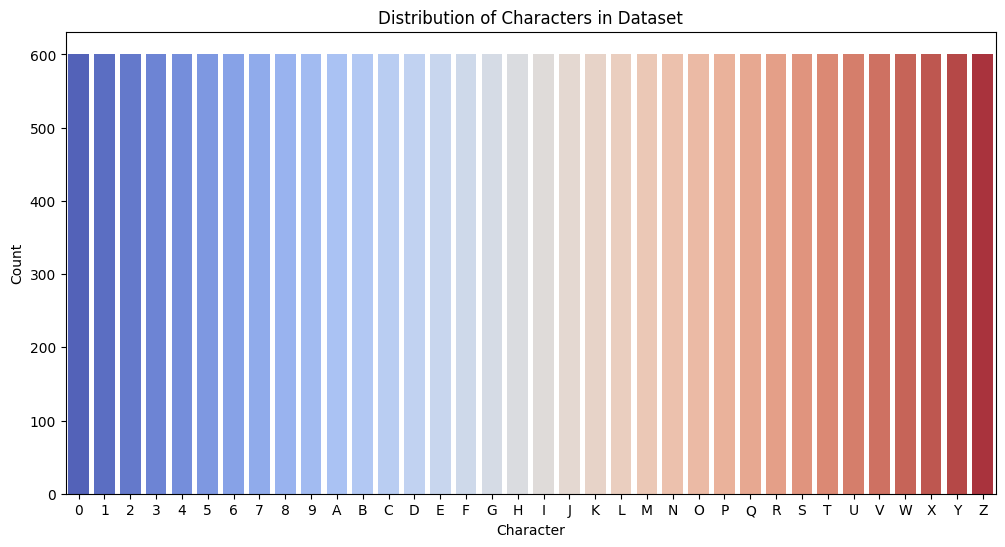

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up directories
train_dir = './input/standard-ocr-dataset/data/training_data'
test_dir = './input/standard-ocr-dataset/data/testing_data'

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical')

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical')

# Concatenate training and testing data
all_data = np.concatenate([train_data.labels, test_data.labels])

# Create character list
characters = [chr(i) for i in range(48, 58)] + [chr(i) for i in range(65, 91)]

# Create countplot of character distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=all_data, palette='coolwarm')
plt.xlabel('Character')
plt.ylabel('Count')
plt.xticks(np.arange(36), characters)
plt.title('Distribution of Characters in Dataset')
plt.show()


## 2.3. Preview of the Dataset with Random Images


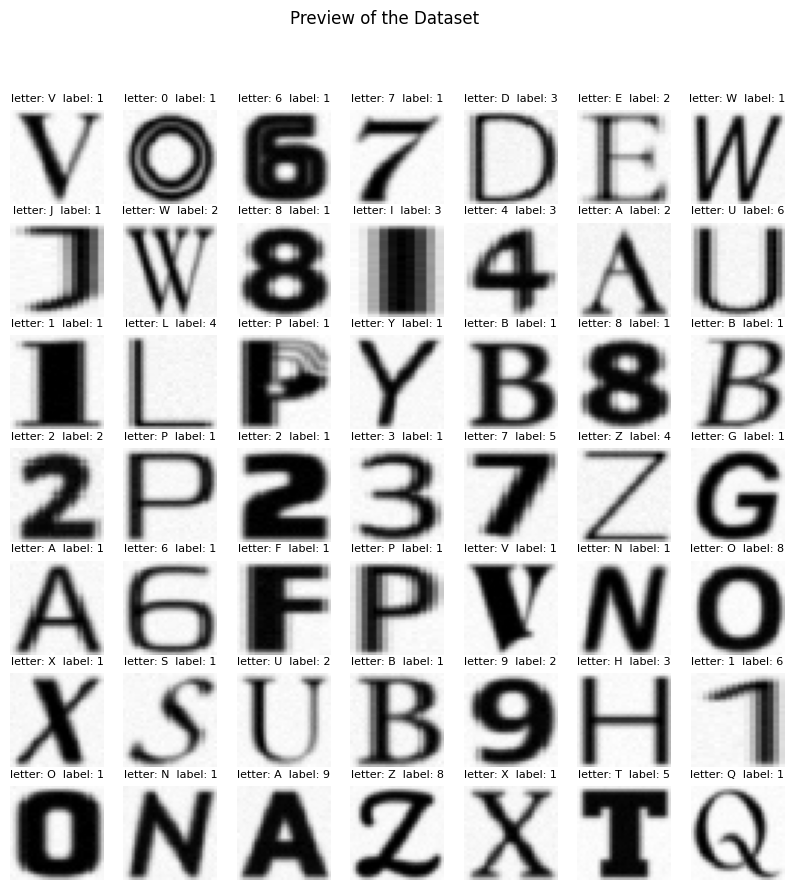

In [7]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

fig, axe = plt.subplots(7, 7, figsize=(10, 10))
fig.suptitle('Preview of the Dataset')

for i in range(7):
    for j in range(7):
        idx = i*7+j
        label_dir = os.path.join('./input/standard-ocr-dataset/data/training_data', str(
            random.choice(list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"))))
        img_path = os.path.join(
            label_dir, random.choice(os.listdir(label_dir)))
        img = Image.open(img_path)
        img = img.resize((32, 32), resample=Image.BOX)
        axe[i, j].imshow(img, cmap='gray')
        axe[i, j].set_title('letter: {}  label: {}'.format(
            os.path.basename(label_dir), os.path.basename(img_path)[0]), fontsize=8)
        axe[i, j].axis('off')

plt.show()


## 2.4. Defining ImageDataGenerator Objects for Data Augmentation and Normalization


In [8]:
# Define an ImageDataGenerator object for data augmentation with the following settings:
augmented_image_gen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to range [0, 1]
    rotation_range=15,  # randomly rotate images up to 15 degrees
    width_shift_range=0.1,  # randomly shift the width of the image by up to 10%
    height_shift_range=0.1,  # randomly shift the height of the image by up to 10%
    shear_range=0.1,  # randomly apply shear transformation up to 10%
    zoom_range=0.1,  # randomly zoom into the image up to 10%
    horizontal_flip=False,  # do not horizontally flip the image
    fill_mode='nearest',  # use nearest pixel to fill gaps after transformations
    # randomly adjust brightness between 50% and 150%
    brightness_range=[0.5, 1.5],
    validation_split=0.2  # split the data into training and validation sets with 80/20 ratio
)

# Define an ImageDataGenerator object for normalizing the pixel values of test images
normal_image_gen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to range [0, 1]
    validation_split=0.2  # split the data into training and validation sets with 80/20 ratio
)


## 2.5. Setting up image data generators for training and validation sets


In [9]:
# Define constants and variables
batch_size = 32
epochs = 32
image_height = 32
image_width = 32
seed = 12345
data_dir = "./input/standard-ocr-dataset/data/"

# Create image data generators
train_data_gen = augmented_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=data_dir + "training_data",
    color_mode="grayscale",
    shuffle=True,
    target_size=(image_height, image_width),
    class_mode="categorical",
    seed=seed,
    subset='training'
)

val_data_gen = normal_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=data_dir + "testing_data",
    color_mode="grayscale",
    shuffle=True,
    target_size=(image_height, image_width),
    class_mode="categorical",
    seed=seed,
    subset='validation'
)


Found 16524 images belonging to 36 classes.
Found 180 images belonging to 36 classes.


# 3. Creating the Deep Learning Model


## 3.1. Defining and compiling a Convolutional Neural Network (CNN) for image classification using Keras.


In [10]:
# Import SGD optimizer from Keras library
from tensorflow.keras.optimizers import SGD

# Define the architecture of a Convolutional Neural Network (CNN)


def define_model():
    # Instantiate a sequential model
    model = Sequential()

    # Add a 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and He uniform weight initialization
    model.add(Conv2D(32, (3, 3), activation='relu',
              kernel_initializer='he_uniform', input_shape=(32, 32, 1)))

    # Add a max pooling layer with a 2x2 pool size
    model.add(MaxPooling2D((2, 2)))

    # Add a flatten layer to convert the 2D feature maps to 1D feature vectors
    model.add(Flatten())

    # Add a fully connected layer with 100 neurons, ReLU activation, and He uniform weight initialization
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

    # Add a final fully connected layer with 36 neurons (one for each class), softmax activation, and default weight initialization
    model.add(Dense(36, activation='softmax'))

    # Return the model
    return model


# Instantiate the model
model = define_model()

# Define optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])


## 3.2. Testing an OCR model on a standard dataset and generating classification report and confusion matrix.


32/32 [==============================] - 0s 4ms/step


C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00        28
           9       0.00      0.00      0.00        28
           A       0.00      0.00      0.00        28
           B       0.00      0.00      0.00        28
           C       0.00      0.00      0.00        28
           D       0.00      0.00      0.00        28
           E       0.00      0.00      0.00        28
           F       0.00      0.00      0.00        28
           G       0.00      0.00      0.00        28
           H       0.00    

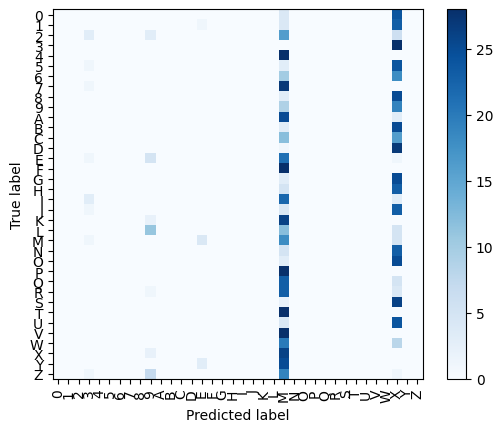

In [11]:
import os
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix

test_dir = './input/standard-ocr-dataset/data/testing_data'
classes = os.listdir(test_dir)
num_classes = len(classes)

# Load images and labels for each subfolder
X_test = []
y_test = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize image to match input size of your model
        img = cv2.resize(img, (32, 32))
        X_test.append(img)
        y_test.append(class_idx)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Make predictions
y_pred = model.predict(X_test)

# Get predicted class labels
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(num_classes), classes, rotation=90)
plt.yticks(np.arange(num_classes), classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## 3.3. Defining Callbacks and Training the Model


In [12]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Prepare callbacks
EarlyStop_callback = EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('./checkpoint',
                             monitor='val_loss', mode='min', save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                       patience=3, min_lr=0.00001)
my_callback = [EarlyStop_callback, checkpoint]

# Training our model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])

# set logging level to INFO to avoid warning messages
tf.get_logger().setLevel('INFO')
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=32,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=my_callback)


Epoch 1/32
516/516 [==============================] - ETA: 0s - loss: 2.6746 - categorical_accuracy: 0.2174

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 25s 47ms/step - loss: 2.6746 - categorical_accuracy: 0.2174 - val_loss: 0.9457 - val_categorical_accuracy: 0.7125
Epoch 2/32
516/516 [==============================] - ETA: 0s - loss: 1.3943 - categorical_accuracy: 0.5785

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 23s 44ms/step - loss: 1.3943 - categorical_accuracy: 0.5785 - val_loss: 0.2811 - val_categorical_accuracy: 0.8875
Epoch 3/32
515/516 [============================>.] - ETA: 0s - loss: 0.7526 - categorical_accuracy: 0.7834

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 21s 41ms/step - loss: 0.7523 - categorical_accuracy: 0.7833 - val_loss: 0.1292 - val_categorical_accuracy: 0.9438
Epoch 4/32
516/516 [==============================] - 20s 39ms/step - loss: 0.5499 - categorical_accuracy: 0.8471 - val_loss: 0.1835 - val_categorical_accuracy: 0.9438
Epoch 5/32
515/516 [============================>.] - ETA: 0s - loss: 0.4813 - categorical_accuracy: 0.8670

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 20s 39ms/step - loss: 0.4810 - categorical_accuracy: 0.8671 - val_loss: 0.1037 - val_categorical_accuracy: 0.9563
Epoch 6/32
515/516 [============================>.] - ETA: 0s - loss: 0.4364 - categorical_accuracy: 0.8785

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 22s 43ms/step - loss: 0.4363 - categorical_accuracy: 0.8785 - val_loss: 0.0687 - val_categorical_accuracy: 0.9688
Epoch 7/32
516/516 [==============================] - 21s 41ms/step - loss: 0.4074 - categorical_accuracy: 0.8821 - val_loss: 0.0740 - val_categorical_accuracy: 0.9688
Epoch 8/32
516/516 [==============================] - 20s 39ms/step - loss: 0.3798 - categorical_accuracy: 0.8936 - val_loss: 0.1418 - val_categorical_accuracy: 0.9250
Epoch 9/32
516/516 [==============================] - 20s 38ms/step - loss: 0.3760 - categorical_accuracy: 0.8978 - val_loss: 0.1378 - val_categorical_accuracy: 0.9312
Epoch 10/32
516/516 [==============================] - 19s 37ms/step - loss: 0.3595 - categorical_accuracy: 0.8989 - val_loss: 0.1133 - val_categorical_accuracy: 0.9563
Epoch 11/32
516/516 [==============================] - 24s 47ms/step - loss: 0.3416 - categorical_accuracy: 0.9030 - val_loss: 0.1172 - val_categorical_accuracy: 0.9563
E

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 30s 58ms/step - loss: 0.3347 - categorical_accuracy: 0.9050 - val_loss: 0.0600 - val_categorical_accuracy: 0.9750
Epoch 13/32
516/516 [==============================] - ETA: 0s - loss: 0.3241 - categorical_accuracy: 0.9079

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 26s 50ms/step - loss: 0.3241 - categorical_accuracy: 0.9079 - val_loss: 0.0539 - val_categorical_accuracy: 0.9688
Epoch 14/32
516/516 [==============================] - 27s 52ms/step - loss: 0.2970 - categorical_accuracy: 0.9135 - val_loss: 0.0648 - val_categorical_accuracy: 0.9563
Epoch 15/32
516/516 [==============================] - 25s 48ms/step - loss: 0.2870 - categorical_accuracy: 0.9194 - val_loss: 0.0761 - val_categorical_accuracy: 0.9563
Epoch 16/32
516/516 [==============================] - 23s 45ms/step - loss: 0.2757 - categorical_accuracy: 0.9224 - val_loss: 0.0564 - val_categorical_accuracy: 0.9563
Epoch 17/32
516/516 [==============================] - 24s 46ms/step - loss: 0.2706 - categorical_accuracy: 0.9212 - val_loss: 0.0695 - val_categorical_accuracy: 0.9625
Epoch 18/32
516/516 [==============================] - 29s 56ms/step - loss: 0.2670 - categorical_accuracy: 0.9221 - val_loss: 0.0587 - val_categorical_accuracy: 0.975

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 29s 55ms/step - loss: 0.2706 - categorical_accuracy: 0.9219 - val_loss: 0.0414 - val_categorical_accuracy: 0.9875
Epoch 20/32
516/516 [==============================] - 89s 172ms/step - loss: 0.2540 - categorical_accuracy: 0.9248 - val_loss: 0.0544 - val_categorical_accuracy: 0.9625
Epoch 21/32
516/516 [==============================] - 31s 60ms/step - loss: 0.2539 - categorical_accuracy: 0.9260 - val_loss: 0.0571 - val_categorical_accuracy: 0.9563
Epoch 22/32
516/516 [==============================] - 35s 68ms/step - loss: 0.2638 - categorical_accuracy: 0.9213 - val_loss: 0.0663 - val_categorical_accuracy: 0.9625
Epoch 23/32
516/516 [==============================] - 29s 57ms/step - loss: 0.2427 - categorical_accuracy: 0.9295 - val_loss: 0.0420 - val_categorical_accuracy: 0.9688
Epoch 24/32
516/516 [==============================] - 31s 60ms/step - loss: 0.2471 - categorical_accuracy: 0.9240 - val_loss: 0.0625 - val_categorical_accuracy: 0.96

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 42s 81ms/step - loss: 0.2330 - categorical_accuracy: 0.9301 - val_loss: 0.0374 - val_categorical_accuracy: 0.9750
Epoch 27/32
516/516 [==============================] - 46s 89ms/step - loss: 0.2257 - categorical_accuracy: 0.9315 - val_loss: 0.0593 - val_categorical_accuracy: 0.9563
Epoch 28/32
516/516 [==============================] - 31s 58ms/step - loss: 0.2245 - categorical_accuracy: 0.9323 - val_loss: 0.0515 - val_categorical_accuracy: 0.9625
Epoch 29/32
516/516 [==============================] - 24s 47ms/step - loss: 0.2233 - categorical_accuracy: 0.9316 - val_loss: 0.0737 - val_categorical_accuracy: 0.9688
Epoch 30/32
516/516 [==============================] - 24s 47ms/step - loss: 0.2158 - categorical_accuracy: 0.9325 - val_loss: 0.0410 - val_categorical_accuracy: 0.9688
Epoch 31/32
516/516 [==============================] - 26s 50ms/step - loss: 0.2206 - categorical_accuracy: 0.9309 - val_loss: 0.0684 - val_categorical_accuracy: 0.956

# 4. Testing and Evaluating the Model


## 4.1. Testing the Trained Model on New Data and Generating Classification Metrics


In [14]:
import os
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix

test_dir = './input/standard-ocr-dataset/data/testing_data'
classes = os.listdir(test_dir)
num_classes = len(classes)

# Load images and labels for each subfolder
X_test = []
y_test = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32, 32)) # Resize image to match input size of your model
        X_test.append(img)
        y_test.append(class_idx)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Make predictions
y_pred = model.predict(X_test)

# Get predicted class labels
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(num_classes), classes, rotation=90)
plt.yticks(np.arange(num_classes), classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 24)

## 4.2. Plotting Training and Validation Accuracy/Loss over Epochs


In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, 33, 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(linestyle='--')

highest_val_acc = max(val_acc)
highest_val_acc_idx = val_acc.index(highest_val_acc) + 1
highest_train_acc = acc[highest_val_acc_idx-1]

plt.annotate(f'Highest Validation Accuracy: {highest_val_acc:.4f}', xy=(highest_val_acc_idx, highest_val_acc),
             xytext=(highest_val_acc_idx, highest_val_acc-0.1), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(f'Training Accuracy at Highest Validation: {highest_train_acc:.4f}', xy=(highest_val_acc_idx, highest_train_acc),
             xytext=(highest_val_acc_idx-2, highest_train_acc-0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(linestyle='--')

plt.show()


## 4.3. Generating Test Data for Image Classification using ImageDataGenerator


In [ ]:
# Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image height and width
image_height = 32
image_width = 32

# Create ImageDataGenerator object for normalizing test images
normal_image_gen = ImageDataGenerator(
    samplewise_center=True,        # set each sample mean to 0
    samplewise_std_normalization=True  # divide each input by its std
)

# Generate test data from directory using ImageDataGenerator
test_data_gen = normal_image_gen.flow_from_directory(
    # path to testing images directory
    directory="./input/standard-ocr-dataset/data/testing_data",
    target_size=(image_height, image_width),     # resize images to this size
    color_mode="grayscale",         # convert images to grayscale
    class_mode="categorical",       # return 2D one-hot encoded labels
    shuffle=True,                   # shuffle order of the images
    batch_size=1008                 # number of images to be yielded per batch
)


## 4.4. Extracting predictions and labels for test data using a trained TensorFlow model.


In [ ]:
# Import required libraries
import tensorflow as tf
from PIL import Image

# Generate test data and labels
test_images, test_labels = next(test_data_gen)

# Get filenames for test data
filenames = test_data_gen.filenames

# Make predictions on test data
test_pred = model.predict(test_images)

# Import necessary libraries

# Get true labels by finding the index of the maximum value in each row of test_labels
true_labels = tf.argmax(test_labels, 1)

# Get predicted labels by finding the index of the maximum value in each row of test_pred
predicted_labels = tf.argmax(test_pred, 1)


## 4.5. Testing the model's performance on sample images.


In [ ]:
# Demonstrate that the model works

mapping = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
    19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
    28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'
}

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/H/28399.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/E/29008.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/L/28727.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/L/29159.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/O/28406.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)


In [ ]:
# Define the path to the "word1" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word1"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word1", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


In [ ]:
# Define the path to the "word2" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word2"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word2", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


In [ ]:
# Define the path to the "word3" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word3"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word3", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


# 5. Retraining the Model at 5 Epochs


## 5.1. Defining and compiling a Convolutional Neural Network (CNN) model for classification using Keras library.


In [ ]:
# Import SGD optimizer from Keras library
from tensorflow.keras.optimizers import SGD

# Define the architecture of a Convolutional Neural Network (CNN)


def define_model():
    # Instantiate a sequential model
    model = Sequential()

    # Add a 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and He uniform weight initialization
    model.add(Conv2D(5, (3, 3), activation='relu',
              kernel_initializer='he_uniform', input_shape=(32, 32, 1)))

    # Add a max pooling layer with a 2x2 pool size
    model.add(MaxPooling2D((2, 2)))

    # Add a flatten layer to convert the 2D feature maps to 1D feature vectors
    model.add(Flatten())

    # Add a fully connected layer with 100 neurons, ReLU activation, and He uniform weight initialization
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

    # Add a final fully connected layer with 36 neurons (one for each class), softmax activation, and default weight initialization
    model.add(Dense(36, activation='softmax'))

    # Return the model
    return model


# Instantiate the model
model = define_model()

# Define optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])


## 5.2. Modifying and Training the Model with Callbacks.


In [ ]:
# Changing number of epochs to 5
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Prepare callbacks
EarlyStop_callback = EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('./checkpoint',
                             monitor='val_loss', mode='min', save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                       patience=3, min_lr=0.00001)
my_callback = [EarlyStop_callback, checkpoint]

# Training our model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])

# set logging level to INFO to avoid warning messages
tf.get_logger().setLevel('INFO')
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=5,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=my_callback)


## 5.3. Testing and evaluating the performance of a trained image classification model on a standard OCR dataset.


In [ ]:
import os
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix

test_dir = './input/standard-ocr-dataset/data/testing_data'
classes = os.listdir(test_dir)
num_classes = len(classes)

# Load images and labels for each subfolder
X_test = []
y_test = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize image to match input size of your model
        img = cv2.resize(img, (32, 32))
        X_test.append(img)
        y_test.append(class_idx)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Make predictions
y_pred = model.predict(X_test)

# Get predicted class labels
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(num_classes), classes, rotation=90)
plt.yticks(np.arange(num_classes), classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## 5.4. Plotting Training and Validation Accuracy/Loss over Epochs with Annotations


In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, 6, 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(linestyle='--')

highest_val_acc = max(val_acc)
highest_val_acc_idx = val_acc.index(highest_val_acc) + 1
highest_train_acc = acc[highest_val_acc_idx-1]

plt.annotate(f'Highest Validation Accuracy: {highest_val_acc:.4f}', xy=(highest_val_acc_idx, highest_val_acc),
             xytext=(highest_val_acc_idx, highest_val_acc-0.1), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(f'Training Accuracy at Highest Validation: {highest_train_acc:.4f}', xy=(highest_val_acc_idx, highest_train_acc),
             xytext=(highest_val_acc_idx-2, highest_train_acc-0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(linestyle='--')

plt.subplots_adjust(wspace=0.9)
plt.show()


## 5.5. Testing the model's performance on sample images.


In [ ]:
# Demonstrate that the model works

mapping = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
    19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
    28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'
}

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/H/28399.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/E/29008.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/L/28727.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/L/29159.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/O/28406.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)


In [ ]:
# Define the path to the "word1" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word1"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word1", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


In [ ]:
# Define the path to the "word2" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word2"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word2", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


In [ ]:
# Define the path to the "word3" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word3"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word3", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)
